In [294]:
import numpy as np
from sklearn.svm import SVR
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing


In [334]:
batting_data_path = 'bsb_ref.csv'
# INFO:
# 101,332 Players with up to 20 features each (exluding year, including team)
# if metric not reported for player, set to 0.0 by default

df_original = pd.read_csv(batting_data_path)
df = df_original.fillna(df.mean()) # fixing this could really help with results potentially
df_recent_players = df[df.year_ID >= 1975] 
df_just_hitters = df_recent_players[df_recent_players.pitcher == 'N']
players = list(set(df_probably_not_pitchers['name_common'])) # just a set of all players

players_with_more_than_20_years = [player for player in players if len(df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player]) >= 16]

['Kirk Gibson', 'Stan Javier', 'Tim Raines', 'Willie Randolph', 'Carlton Fisk', 'Harold Baines', 'Jose Canseco', 'Jose Guillen', 'Dave Collins', 'Brady Anderson', 'Dave Martinez', 'Luis Castillo', 'Jose Reyes', 'Adrian Beltre', 'Aramis Ramirez', 'Alex Rodriguez', 'Mark Teixeira', 'Brian Giles', 'Edgar Martinez', 'Devon White', 'Edwin Encarnacion', 'Matt Stairs', 'Lenny Harris', 'Raul Ibanez', 'Dave Magadan', 'Russell Branyan', 'Terry Pendleton', 'Mike Cameron', 'Carlos Baerga', 'Jeff Reed', 'Jay Bell', 'Tino Martinez', 'Jim Edmonds', 'Kenny Lofton', 'Torii Hunter', 'Craig Counsell', 'Moises Alou', 'Jerry Hairston', 'Bernie Williams', 'Coco Crisp', 'Jeff Kent', 'Damion Easley', 'Jose Cruz', 'Brian Downing', 'Delino DeShields', 'Barry Bonds', 'Garry Templeton', 'Tony Armas', 'Derek Jeter', 'Robin Ventura', 'John Olerud', 'Jeff Conine', 'Luis Gonzalez', 'Jim Gantner', 'Benito Santiago', 'David Ortiz', 'Eric Young Sr.', 'Reggie Sanders', 'Shawon Dunston', 'Mike Sweeney', 'Lance Berkman', '

In [603]:
def prepare_test_train(player_x_data, player_y_data):
    i_0, i_1 = 14, 15# hardcoded for now. these are just the ranges described above
    x_train = player_x_data[:i_0]
    y_train = player_y_data[:i_0]
    x_test = player_x_data[i_0:i_1]
    y_test = player_y_data[i_0:i_1]
    return (x_train, y_train, x_test, y_test)

In [604]:
from sklearn import preprocessing

def prepare_rows(player_rows):
    player_x_data = np.asarray([i for i in range(len(player_rows))]).reshape(-1,1)
    player_y_data = player_rows[['OPS_plus']].values
    return (player_x_data, player_y_data)

In [605]:
def run_svr(data_tuple):
    x_train, y_train, x_test, y_test = data_tuple
    #print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    parameters = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,150,1000, 10e5],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e2, 1e8],
    "epsilon": [0.1, 1e-4, 1e2]
    }

    svr = GridSearchCV(SVR(), parameters, cv=3)
    svr.fit(x_train, y_train.ravel())

    y_svr_pred = svr.predict(x_test)
    print("Actual OPS_plus", y_test.ravel())
    print("Predicted OPS_plus", y_svr_pred)
    
    mse = mean_squared_error(y_test, y_svr_pred)
    mae = mean_absolute_error(y_test, y_svr_pred)
    print('Score: %.3f' % svr.score(x_train, y_train))
    print("Mean squared error: %.3f" % mse)
    print('Mean Absolute error: %.3f' % mae)
    print('Variance score: %.3f' % r2_score(y_test, y_svr_pred))
    print()
    
    return (y_test, y_svr_pred, mae, mse)


    

In [606]:
# let's try this again but better...
from collections import defaultdict
loss_dict = defaultdict(float)
tot_mse_loss = 0
tot_mae_loss = 0
y_true = []
y_pred = []

for player in players_with_more_than_20_years:
    print(player)
    player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player]
    data = prepare_rows(player_rows)
    data_tuple = prepare_test_train(data[0], data[1])
    results = run_svr(data_tuple)
    loss_dict[player] = results
    y_true.append(results[0][0])
    y_pred.append(results[1][0])
    tot_mse_loss += loss_dict[player][-1]
    tot_mae_loss += loss_dict[player][-2]

Kirk Gibson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [130.1477]
Predicted OPS_plus [109.7780476]
Score: 0.353
Mean squared error: 414.923
Mean Absolute error: 20.370
Variance score: 0.000

Stan Javier


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [111.3957]
Predicted OPS_plus [106.25896241]
Score: 0.330
Mean squared error: 26.386
Mean Absolute error: 5.137
Variance score: 0.000

Tim Raines


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [111.0607]
Predicted OPS_plus [105.81118439]
Score: 0.537
Mean squared error: 27.557
Mean Absolute error: 5.250
Variance score: 0.000

Willie Randolph


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [100.8685]
Predicted OPS_plus [105.39950137]
Score: -0.024
Mean squared error: 20.530
Mean Absolute error: 4.531
Variance score: 0.000

Carlton Fisk


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [135.9149]
Predicted OPS_plus [101.83628567]
Score: 0.096
Mean squared error: 1161.352
Mean Absolute error: 34.079
Variance score: 0.000

Harold Baines


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [107.9611]
Predicted OPS_plus [133.56468778]
Score: 0.169
Mean squared error: 655.544
Mean Absolute error: 25.604
Variance score: 0.000

Jose Canseco


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [114.0238]
Predicted OPS_plus [137.25415046]
Score: -0.016
Mean squared error: 539.649
Mean Absolute error: 23.230
Variance score: 0.000

Jose Guillen


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [95.0206]
Predicted OPS_plus [118.17345379]
Score: 0.241
Mean squared error: 536.055
Mean Absolute error: 23.153
Variance score: 0.000

Dave Collins


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [63.5211]
Predicted OPS_plus [86.5304]
Score: -0.038
Mean squared error: 529.428
Mean Absolute error: 23.009
Variance score: 0.000

Brady Anderson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [66.3886]
Predicted OPS_plus [102.78764384]
Score: 0.572
Mean squared error: 1324.890
Mean Absolute error: 36.399
Variance score: 0.000

Dave Martinez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [91.8827]
Predicted OPS_plus [96.107075]
Score: 0.319
Mean squared error: 17.845
Mean Absolute error: 4.224
Variance score: 0.000

Luis Castillo


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [98.5305]
Predicted OPS_plus [84.82609871]
Score: 0.543
Mean squared error: 187.811
Mean Absolute error: 13.704
Variance score: 0.000

Jose Reyes


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [106.4849]
Predicted OPS_plus [90.62961211]
Score: 0.231
Mean squared error: 251.390
Mean Absolute error: 15.855
Variance score: 0.000

Adrian Beltre


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [139.4315]
Predicted OPS_plus [117.85990956]
Score: 0.115
Mean squared error: 465.334
Mean Absolute error: 21.572
Variance score: 0.000

Aramis Ramirez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [135.9639]
Predicted OPS_plus [92.06956147]
Score: 0.681
Mean squared error: 1926.713
Mean Absolute error: 43.894
Variance score: 0.000

Alex Rodriguez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [149.5793]
Predicted OPS_plus [157.19005251]
Score: 0.522
Mean squared error: 57.924
Mean Absolute error: 7.611
Variance score: 0.000

Mark Teixeira


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [143.8735]
Predicted OPS_plus [94.76028454]
Score: 0.551
Mean squared error: 2412.108
Mean Absolute error: 49.113
Variance score: 0.000

Brian Giles


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [147.2024]
Predicted OPS_plus [126.88392588]
Score: 0.710
Mean squared error: 412.840
Mean Absolute error: 20.318
Variance score: 0.000

Edgar Martinez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [140.8377]
Predicted OPS_plus [145.9360822]
Score: 0.290
Mean squared error: 25.994
Mean Absolute error: 5.098
Variance score: 0.000

Devon White


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [79.285]
Predicted OPS_plus [94.87335]
Score: 0.143
Mean squared error: 242.997
Mean Absolute error: 15.588
Variance score: 0.000

Edwin Encarnacion


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [116.3378]
Predicted OPS_plus [120.87125146]
Score: 0.900
Mean squared error: 20.552
Mean Absolute error: 4.533
Variance score: 0.000

Matt Stairs


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [97.9181]
Predicted OPS_plus [106.45927627]
Score: 0.001
Mean squared error: 72.952
Mean Absolute error: 8.541
Variance score: 0.000

Lenny Harris


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [15.5923]
Predicted OPS_plus [82.37103333]
Score: 0.067
Mean squared error: 4459.399
Mean Absolute error: 66.779
Variance score: 0.000

Raul Ibanez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [102.7595]
Predicted OPS_plus [100.41039765]
Score: 0.662
Mean squared error: 5.518
Mean Absolute error: 2.349
Variance score: 0.000

Dave Magadan


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [106.9582]
Predicted OPS_plus [118.55734988]
Score: 0.201
Mean squared error: 134.540
Mean Absolute error: 11.599
Variance score: 0.000

Russell Branyan


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [70.6228]
Predicted OPS_plus [115.95025]
Score: -0.001
Mean squared error: 2054.578
Mean Absolute error: 45.327
Variance score: 0.000

Terry Pendleton


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [75.4017]
Predicted OPS_plus [83.05294857]
Score: 0.217
Mean squared error: 58.542
Mean Absolute error: 7.651
Variance score: 0.000

Mike Cameron


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [27.8689]
Predicted OPS_plus [108.62175176]
Score: -0.035
Mean squared error: 6521.023
Mean Absolute error: 80.753
Variance score: 0.000

Carlos Baerga


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [62.4698]
Predicted OPS_plus [121.23104322]
Score: 0.775
Mean squared error: 3452.884
Mean Absolute error: 58.761
Variance score: 0.000

Jeff Reed


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [66.8307]
Predicted OPS_plus [85.40791825]
Score: 0.493
Mean squared error: 345.113
Mean Absolute error: 18.577
Variance score: 0.000

Jay Bell


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [87.5529]
Predicted OPS_plus [108.62263769]
Score: 0.290
Mean squared error: 443.934
Mean Absolute error: 21.070
Variance score: 0.000

Tino Martinez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [116.8379]
Predicted OPS_plus [105.61191562]
Score: 0.092
Mean squared error: 126.023
Mean Absolute error: 11.226
Variance score: 0.000

Jim Edmonds


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [88.1939]
Predicted OPS_plus [121.98264251]
Score: 0.572
Mean squared error: 1141.679
Mean Absolute error: 33.789
Variance score: 0.000

Kenny Lofton


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [97.5808]
Predicted OPS_plus [105.4825158]
Score: 0.041
Mean squared error: 62.437
Mean Absolute error: 7.902
Variance score: 0.000

Torii Hunter


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [115.3168]
Predicted OPS_plus [130.77360686]
Score: 0.601
Mean squared error: 238.913
Mean Absolute error: 15.457
Variance score: 0.000

Craig Counsell


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [74.0503]
Predicted OPS_plus [77.43565]
Score: 0.051
Mean squared error: 11.461
Mean Absolute error: 3.385
Variance score: 0.000

Moises Alou


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [136.6959]
Predicted OPS_plus [128.4713]
Score: -0.002
Mean squared error: 67.644
Mean Absolute error: 8.225
Variance score: 0.000

Jerry Hairston


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.8493]
Predicted OPS_plus [95.56681286]
Score: 0.293
Mean squared error: 86.165
Mean Absolute error: 9.282
Variance score: 0.000

Bernie Williams


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [84.9096]
Predicted OPS_plus [97.33518616]
Score: 0.855
Mean squared error: 154.395
Mean Absolute error: 12.426
Variance score: 0.000

Coco Crisp


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [82.5009]
Predicted OPS_plus [101.27818588]
Score: -0.083
Mean squared error: 352.586
Mean Absolute error: 18.777
Variance score: 0.000

Jeff Kent


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [122.7239]
Predicted OPS_plus [138.9897233]
Score: 0.450
Mean squared error: 264.577
Mean Absolute error: 16.266
Variance score: 0.000

Damion Easley


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [95.2248]
Predicted OPS_plus [100.75550504]
Score: -0.071
Mean squared error: 30.589
Mean Absolute error: 5.531
Variance score: 0.000

Jose Cruz


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [120.3735]
Predicted OPS_plus [104.27583053]
Score: 0.290
Mean squared error: 259.135
Mean Absolute error: 16.098
Variance score: 0.000

Brian Downing


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [118.3512]
Predicted OPS_plus [126.62253658]
Score: 0.458
Mean squared error: 68.415
Mean Absolute error: 8.271
Variance score: 0.000

Delino DeShields


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [94.6567]
Predicted OPS_plus [86.20646292]
Score: 0.126
Mean squared error: 71.407
Mean Absolute error: 8.450
Variance score: 0.000

Barry Bonds


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [187.9919]
Predicted OPS_plus [144.53717788]
Score: 0.812
Mean squared error: 1888.313
Mean Absolute error: 43.455
Variance score: 0.000

Garry Templeton


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [75.0909]
Predicted OPS_plus [86.21239203]
Score: 0.429
Mean squared error: 123.688
Mean Absolute error: 11.121
Variance score: 0.000

Tony Armas


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [-33.1163]
Predicted OPS_plus [95.52766987]
Score: -0.025
Mean squared error: 16549.271
Mean Absolute error: 128.644
Variance score: 0.000

Derek Jeter


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [124.5424]
Predicted OPS_plus [122.25785]
Score: 0.001
Mean squared error: 5.219
Mean Absolute error: 2.285
Variance score: 0.000

Robin Ventura


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [100.1997]
Predicted OPS_plus [116.16369443]
Score: -0.021
Mean squared error: 254.849
Mean Absolute error: 15.964
Variance score: 0.000

John Olerud


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [101.3637]
Predicted OPS_plus [125.4928]
Score: 0.018
Mean squared error: 582.213
Mean Absolute error: 24.129
Variance score: 0.000

Jeff Conine


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [110.0343]
Predicted OPS_plus [105.1307625]
Score: 0.694
Mean squared error: 24.045
Mean Absolute error: 4.904
Variance score: 0.000

Luis Gonzalez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [117.6018]
Predicted OPS_plus [134.36848181]
Score: 0.467
Mean squared error: 281.122
Mean Absolute error: 16.767
Variance score: 0.000

Jim Gantner


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [90.3017]
Predicted OPS_plus [82.32215959]
Score: 0.451
Mean squared error: 63.673
Mean Absolute error: 7.980
Variance score: 0.000

Benito Santiago


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [76.0703]
Predicted OPS_plus [75.14313477]
Score: 0.064
Mean squared error: 0.860
Mean Absolute error: 0.927
Variance score: 0.000

David Ortiz


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [173.281]
Predicted OPS_plus [136.34655]
Score: -0.041
Mean squared error: 1364.154
Mean Absolute error: 36.934
Variance score: 0.000

Eric Young Sr.


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [92.7968]
Predicted OPS_plus [91.29085888]
Score: -0.027
Mean squared error: 2.268
Mean Absolute error: 1.506
Variance score: 0.000

Reggie Sanders


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.7524]
Predicted OPS_plus [122.40343314]
Score: -0.076
Mean squared error: 1343.298
Mean Absolute error: 36.651
Variance score: 0.000

Shawon Dunston


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [61.3331]
Predicted OPS_plus [85.30090766]
Score: 0.091
Mean squared error: 574.456
Mean Absolute error: 23.968
Variance score: 0.000

Mike Sweeney


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.116]
Predicted OPS_plus [101.02598535]
Score: 0.409
Mean squared error: 253.128
Mean Absolute error: 15.910
Variance score: 0.000

Lance Berkman


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [126.168]
Predicted OPS_plus [141.3463]
Score: 0.038
Mean squared error: 230.381
Mean Absolute error: 15.178
Variance score: 0.000

Eric Davis


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [150.6262]
Predicted OPS_plus [131.56250489]
Score: 0.304
Mean squared error: 363.424
Mean Absolute error: 19.064
Variance score: 0.000

Cliff Floyd


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [88.1425]
Predicted OPS_plus [119.33655552]
Score: 0.372
Mean squared error: 973.069
Mean Absolute error: 31.194
Variance score: 0.000

Mark Loretta


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [95.5686]
Predicted OPS_plus [84.2637601]
Score: 0.080
Mean squared error: 127.799
Mean Absolute error: 11.305
Variance score: 0.000

Scott Rolen


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [102.5738]
Predicted OPS_plus [124.2141]
Score: 0.043
Mean squared error: 468.303
Mean Absolute error: 21.640
Variance score: 0.000

Darryl Strawberry


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [132.2599]
Predicted OPS_plus [108.87138125]
Score: 0.640
Mean squared error: 547.023
Mean Absolute error: 23.389
Variance score: 0.000

Mark McGwire


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [176.4597]
Predicted OPS_plus [185.020617]
Score: 0.389
Mean squared error: 73.289
Mean Absolute error: 8.561
Variance score: 0.000

Juan Samuel


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [132.3922]
Predicted OPS_plus [103.19665]
Score: -0.053
Mean squared error: 852.380
Mean Absolute error: 29.196
Variance score: 0.000

Rick Cerone


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.0818]
Predicted OPS_plus [103.28284031]
Score: 0.861
Mean squared error: 0.638
Mean Absolute error: 0.799
Variance score: 0.000

Brian Hunter


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [46.4462]
Predicted OPS_plus [59.54574605]
Score: -0.189
Mean squared error: 171.598
Mean Absolute error: 13.100
Variance score: 0.000

Andre Dawson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [135.3076]
Predicted OPS_plus [119.75981429]
Score: 1.000
Mean squared error: 241.734
Mean Absolute error: 15.548
Variance score: 0.000

Claudell Washington


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [100.3563]
Predicted OPS_plus [108.34225]
Score: -0.011
Mean squared error: 63.775
Mean Absolute error: 7.986
Variance score: 0.000

Rondell White


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [122.9467]
Predicted OPS_plus [115.64575]
Score: -0.015
Mean squared error: 53.304
Mean Absolute error: 7.301
Variance score: 0.000

Dale Murphy


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [95.7495]
Predicted OPS_plus [79.35906425]
Score: 0.511
Mean squared error: 268.646
Mean Absolute error: 16.390
Variance score: 0.000

David Segui


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [136.7696]
Predicted OPS_plus [134.66608746]
Score: 0.504
Mean squared error: 4.425
Mean Absolute error: 2.104
Variance score: 0.000

Wade Boggs


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [97.731]
Predicted OPS_plus [126.77757321]
Score: 0.576
Mean squared error: 843.703
Mean Absolute error: 29.047
Variance score: 0.000

Brett Butler


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [95.3836]
Predicted OPS_plus [131.97507535]
Score: 0.448
Mean squared error: 1338.936
Mean Absolute error: 36.591
Variance score: 0.000

Carlos Beltran


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [151.3073]
Predicted OPS_plus [95.83613033]
Score: 0.476
Mean squared error: 3077.051
Mean Absolute error: 55.471
Variance score: 0.000

Bobby Abreu


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [117.6763]
Predicted OPS_plus [119.02405]
Score: -0.420
Mean squared error: 1.816
Mean Absolute error: 1.348
Variance score: 0.000

Ramon Martinez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [77.6988]
Predicted OPS_plus [59.54546155]
Score: 0.674
Mean squared error: 329.544
Mean Absolute error: 18.153
Variance score: 0.000

Craig Biggio


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [87.8738]
Predicted OPS_plus [101.12057246]
Score: 0.563
Mean squared error: 175.477
Mean Absolute error: 13.247
Variance score: 0.000

Darrell Evans


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.6871]
Predicted OPS_plus [138.21412028]
Score: 0.359
Mean squared error: 1124.061
Mean Absolute error: 33.527
Variance score: 0.000

Mike Piazza


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.4545]
Predicted OPS_plus [104.85495827]
Score: 0.251
Mean squared error: 0.160
Mean Absolute error: 0.400
Variance score: 0.000

Greg Myers


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [94.369]
Predicted OPS_plus [86.03405]
Score: -0.024
Mean squared error: 69.471
Mean Absolute error: 8.335
Variance score: 0.000

Keith Hernandez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [119.6767]
Predicted OPS_plus [131.40575]
Score: 0.576
Mean squared error: 137.571
Mean Absolute error: 11.729
Variance score: 0.000

Chris Gomez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [89.7981]
Predicted OPS_plus [74.47107143]
Score: 0.489
Mean squared error: 234.918
Mean Absolute error: 15.327
Variance score: 0.000

Jose Offerman


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [96.7165]
Predicted OPS_plus [88.17525]
Score: 0.034
Mean squared error: 72.953
Mean Absolute error: 8.541
Variance score: 0.000

Alex Gonzalez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [90.5151]
Predicted OPS_plus [58.47916413]
Score: 0.196
Mean squared error: 1026.301
Mean Absolute error: 32.036
Variance score: 0.000

Fred McGriff


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [110.4685]
Predicted OPS_plus [154.24100378]
Score: 0.671
Mean squared error: 1916.032
Mean Absolute error: 43.773
Variance score: 0.000

Adam Dunn


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [120.8584]
Predicted OPS_plus [128.35346667]
Score: 0.387
Mean squared error: 56.176
Mean Absolute error: 7.495
Variance score: 0.000

Sandy Alomar


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [64.0379]
Predicted OPS_plus [79.25102797]
Score: 0.145
Mean squared error: 231.439
Mean Absolute error: 15.213
Variance score: 0.000

Alan Trammell


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [114.4831]
Predicted OPS_plus [119.8097]
Score: -0.133
Mean squared error: 28.373
Mean Absolute error: 5.327
Variance score: 0.000

Julio Franco


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [89.6836]
Predicted OPS_plus [102.01602504]
Score: 0.476
Mean squared error: 152.089
Mean Absolute error: 12.332
Variance score: 0.000

Matt Williams


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [92.0747]
Predicted OPS_plus [72.93445061]
Score: 0.603
Mean squared error: 366.349
Mean Absolute error: 19.140
Variance score: 0.000

Roberto Alomar


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [89.6548]
Predicted OPS_plus [149.04657707]
Score: 0.120
Mean squared error: 3527.383
Mean Absolute error: 59.392
Variance score: 0.000

Mike Stanley


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [115.2541]
Predicted OPS_plus [104.52934725]
Score: 0.928
Mean squared error: 115.020
Mean Absolute error: 10.725
Variance score: 0.000

Cliff Johnson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [81.4883]
Predicted OPS_plus [126.68421008]
Score: 0.040
Mean squared error: 2042.670
Mean Absolute error: 45.196
Variance score: 0.000

Jose Vizcaino


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [89.675]
Predicted OPS_plus [68.56452081]
Score: 0.025
Mean squared error: 445.652
Mean Absolute error: 21.110
Variance score: 0.000

Ken Caminiti


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [74.2289]
Predicted OPS_plus [143.38740035]
Score: 0.483
Mean squared error: 4782.898
Mean Absolute error: 69.159
Variance score: 0.000

Frank White


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [79.607]
Predicted OPS_plus [81.28194075]
Score: 0.250
Mean squared error: 2.805
Mean Absolute error: 1.675
Variance score: 0.000

Gary Carter


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [50.8219]
Predicted OPS_plus [103.33971755]
Score: 0.320
Mean squared error: 2758.121
Mean Absolute error: 52.518
Variance score: 0.000

Frank Thomas


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [155.6554]
Predicted OPS_plus [134.12005681]
Score: 0.485
Mean squared error: 463.771
Mean Absolute error: 21.535
Variance score: 0.000

Todd Helton


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [116.9623]
Predicted OPS_plus [75.60643224]
Score: 0.725
Mean squared error: 1710.308
Mean Absolute error: 41.356
Variance score: 0.000

Rick Dempsey


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [80.4998]
Predicted OPS_plus [88.93485]
Score: 0.070
Mean squared error: 71.150
Mean Absolute error: 8.435
Variance score: 0.000

Jim Dwyer


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [159.5722]
Predicted OPS_plus [122.11175177]
Score: -0.021
Mean squared error: 1403.285
Mean Absolute error: 37.460
Variance score: 0.000

Sammy Sosa


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [160.0321]
Predicted OPS_plus [176.77660237]
Score: 0.659
Mean squared error: 280.378
Mean Absolute error: 16.745
Variance score: 0.000

Dave Winfield


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [129.343]
Predicted OPS_plus [140.78]
Score: -0.075
Mean squared error: 130.805
Mean Absolute error: 11.437
Variance score: 0.000

Glenallen Hill


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [99.6575]
Predicted OPS_plus [137.58150058]
Score: 0.049
Mean squared error: 1438.230
Mean Absolute error: 37.924
Variance score: 0.000

Joe Carter


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [77.1749]
Predicted OPS_plus [98.15046109]
Score: 0.524
Mean squared error: 439.974
Mean Absolute error: 20.976
Variance score: 0.000

Johnny Damon


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [118.1511]
Predicted OPS_plus [116.1374502]
Score: 0.198
Mean squared error: 4.055
Mean Absolute error: 2.014
Variance score: 0.000

Tony Fernandez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [120.7032]
Predicted OPS_plus [97.78395556]
Score: 0.733
Mean squared error: 525.292
Mean Absolute error: 22.919
Variance score: 0.000

Cal Ripken Jr.


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [101.8935]
Predicted OPS_plus [87.76054066]
Score: 0.187
Mean squared error: 199.741
Mean Absolute error: 14.133
Variance score: 0.000

Marquis Grissom


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.1441]
Predicted OPS_plus [92.83135]
Score: -0.001
Mean squared error: 127.978
Mean Absolute error: 11.313
Variance score: 0.000

Lee Mazzilli


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [17.0636]
Predicted OPS_plus [110.1843]
Score: -0.001
Mean squared error: 8671.465
Mean Absolute error: 93.121
Variance score: 0.000

Wally Joyner


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [94.1324]
Predicted OPS_plus [118.16414857]
Score: 0.003
Mean squared error: 577.525
Mean Absolute error: 24.032
Variance score: 0.000

Derrek Lee


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [98.3809]
Predicted OPS_plus [130.90697587]
Score: 0.288
Mean squared error: 1057.946
Mean Absolute error: 32.526
Variance score: 0.000

Ozzie Smith


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [105.2098]
Predicted OPS_plus [118.39947466]
Score: 0.614
Mean squared error: 173.968
Mean Absolute error: 13.190
Variance score: 0.000

A.J. Pierzynski


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [76.1757]
Predicted OPS_plus [94.44486761]
Score: 0.259
Mean squared error: 333.762
Mean Absolute error: 18.269
Variance score: 0.000

Andres Galarraga


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [122.9306]
Predicted OPS_plus [134.82547065]
Score: 0.179
Mean squared error: 141.488
Mean Absolute error: 11.895
Variance score: 0.000

Dave Roberts


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [101.423]
Predicted OPS_plus [94.22627137]
Score: 0.056
Mean squared error: 51.793
Mean Absolute error: 7.197
Variance score: 0.000

Barry Larkin


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [118.1676]
Predicted OPS_plus [132.5893168]
Score: 0.179
Mean squared error: 207.986
Mean Absolute error: 14.422
Variance score: 0.000

Ivan Rodriguez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [94.6839]
Predicted OPS_plus [126.29226639]
Score: 0.703
Mean squared error: 999.089
Mean Absolute error: 31.608
Variance score: 0.000

George Brett


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [123.3825]
Predicted OPS_plus [142.9978526]
Score: 0.007
Mean squared error: 384.762
Mean Absolute error: 19.615
Variance score: 0.000

Tony Phillips


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [109.406]
Predicted OPS_plus [117.6718913]
Score: 0.889
Mean squared error: 68.325
Mean Absolute error: 8.266
Variance score: 0.000

Chipper Jones


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [117.2497]
Predicted OPS_plus [161.28566591]
Score: 0.289
Mean squared error: 1939.166
Mean Absolute error: 44.036
Variance score: 0.000

Phil Nevin


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [66.5071]
Predicted OPS_plus [69.14214265]
Score: 0.352
Mean squared error: 6.943
Mean Absolute error: 2.635
Variance score: 0.000

Ken Griffey


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [74.1701]
Predicted OPS_plus [113.50149104]
Score: 0.130
Mean squared error: 1546.958
Mean Absolute error: 39.331
Variance score: 0.000

Jim Thome


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [84.6784]
Predicted OPS_plus [147.6693]
Score: 0.309
Mean squared error: 3967.853
Mean Absolute error: 62.991
Variance score: 0.000

Gregg Zaun


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [88.9823]
Predicted OPS_plus [92.2726]
Score: -0.017
Mean squared error: 10.826
Mean Absolute error: 3.290
Variance score: 0.000

Jason Kendall


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [71.3554]
Predicted OPS_plus [74.57183124]
Score: 0.476
Mean squared error: 10.345
Mean Absolute error: 3.216
Variance score: 0.000

Mark Kotsay


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [100.7803]
Predicted OPS_plus [53.1589986]
Score: 0.489
Mean squared error: 2267.788
Mean Absolute error: 47.621
Variance score: 0.000

Gary Matthews


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [80.7954]
Predicted OPS_plus [98.48548696]
Score: 0.241
Mean squared error: 312.939
Mean Absolute error: 17.690
Variance score: 0.000

Bobby Bonilla


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [116.8764]
Predicted OPS_plus [123.77116933]
Score: 0.460
Mean squared error: 47.538
Mean Absolute error: 6.895
Variance score: 0.000

Chili Davis


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [123.9392]
Predicted OPS_plus [150.83064238]
Score: 0.326
Mean squared error: 723.150
Mean Absolute error: 26.891
Variance score: 0.000

Paul Konerko


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [140.707]
Predicted OPS_plus [108.82290811]
Score: 0.367
Mean squared error: 1016.595
Mean Absolute error: 31.884
Variance score: 0.000

Todd Zeile


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [109.3095]
Predicted OPS_plus [105.78089436]
Score: -0.008
Mean squared error: 12.451
Mean Absolute error: 3.529
Variance score: 0.000

Tony Clark


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [93.0625]
Predicted OPS_plus [95.87961106]
Score: 0.178
Mean squared error: 7.936
Mean Absolute error: 2.817
Variance score: 0.000

Jose Hernandez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [137.0422]
Predicted OPS_plus [48.92963911]
Score: 0.447
Mean squared error: 7763.823
Mean Absolute error: 88.113
Variance score: 0.000

Ken Oberkfell


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [57.6554]
Predicted OPS_plus [99.6103118]
Score: -0.051
Mean squared error: 1760.215
Mean Absolute error: 41.955
Variance score: 0.000

Dwight Evans


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [135.9932]
Predicted OPS_plus [131.45660667]
Score: 0.374
Mean squared error: 20.581
Mean Absolute error: 4.537
Variance score: 0.000

Rickey Henderson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [155.0572]
Predicted OPS_plus [137.78825]
Score: 0.485
Mean squared error: 298.217
Mean Absolute error: 17.269
Variance score: 0.000

Curtis Granderson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [127.9738]
Predicted OPS_plus [114.35283579]
Score: -0.016
Mean squared error: 185.531
Mean Absolute error: 13.621
Variance score: 0.000

Omar Vizquel


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [77.6276]
Predicted OPS_plus [98.57376441]
Score: 0.466
Mean squared error: 438.742
Mean Absolute error: 20.946
Variance score: 0.000

Randy Velarde


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [113.0839]
Predicted OPS_plus [82.44609771]
Score: 0.048
Mean squared error: 938.675
Mean Absolute error: 30.638
Variance score: 0.000

Matt Holliday


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [94.6044]
Predicted OPS_plus [99.0770268]
Score: 0.645
Mean squared error: 20.004
Mean Absolute error: 4.473
Variance score: 0.000

Miguel Tejada


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [103.5915]
Predicted OPS_plus [71.7096292]
Score: 0.854
Mean squared error: 1016.454
Mean Absolute error: 31.882
Variance score: 0.000

Tony Pena


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [75.2205]
Predicted OPS_plus [68.41657712]
Score: 0.301
Mean squared error: 46.293
Mean Absolute error: 6.804
Variance score: 0.000

Willie McGee


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [81.8733]
Predicted OPS_plus [102.40777857]
Score: 1.000
Mean squared error: 421.665
Mean Absolute error: 20.534
Variance score: 0.000

Fred Lynn


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.796]
Predicted OPS_plus [121.42983004]
Score: 0.065
Mean squared error: 276.684
Mean Absolute error: 16.634
Variance score: 0.000

Chris Young


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.527]
Predicted OPS_plus [125.79781519]
Score: 0.479
Mean squared error: 1621.739
Mean Absolute error: 40.271
Variance score: 0.000

Jason Giambi


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.3051]
Predicted OPS_plus [144.3554]
Score: -0.018
Mean squared error: 3486.938
Mean Absolute error: 59.050
Variance score: 0.000

Rey Sanchez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [80.759]
Predicted OPS_plus [72.14772857]
Score: 0.473
Mean squared error: 74.154
Mean Absolute error: 8.611
Variance score: 0.000

Mark Grace


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [86.1361]
Predicted OPS_plus [120.7105]
Score: -0.002
Mean squared error: 1195.389
Mean Absolute error: 34.574
Variance score: 0.000

Will Clark


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [129.4078]
Predicted OPS_plus [125.46878183]
Score: 0.239
Mean squared error: 15.516
Mean Absolute error: 3.939
Variance score: 0.000

Carlos Lee


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [102.142]
Predicted OPS_plus [118.06105]
Score: -0.025
Mean squared error: 253.416
Mean Absolute error: 15.919
Variance score: 0.000

Lonnie Smith


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [133.5198]
Predicted OPS_plus [114.99141429]
Score: 1.000
Mean squared error: 343.301
Mean Absolute error: 18.528
Variance score: 0.000

Tony Gwynn


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [128.4145]
Predicted OPS_plus [145.00862206]
Score: 0.130
Mean squared error: 275.365
Mean Absolute error: 16.594
Variance score: 0.000

Jim Sundberg


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [115.8636]
Predicted OPS_plus [83.5551]
Score: -0.043
Mean squared error: 1043.839
Mean Absolute error: 32.309
Variance score: 0.000

Greg Maddux


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [10.0314]
Predicted OPS_plus [13.8342]
Score: -0.005
Mean squared error: 14.461
Mean Absolute error: 3.803
Variance score: 0.000

Juan Gonzalez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [122.1286]
Predicted OPS_plus [131.01278795]
Score: -0.033
Mean squared error: 78.929
Mean Absolute error: 8.884
Variance score: 0.000

Bob Boone


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [92.171]
Predicted OPS_plus [62.04948127]
Score: 0.157
Mean squared error: 907.306
Mean Absolute error: 30.122
Variance score: 0.000

Manny Ramirez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [125.5055]
Predicted OPS_plus [152.98155008]
Score: 0.270
Mean squared error: 754.933
Mean Absolute error: 27.476
Variance score: 0.000

Brent Mayne


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [74.7344]
Predicted OPS_plus [75.60496951]
Score: 0.708
Mean squared error: 0.758
Mean Absolute error: 0.871
Variance score: 0.000

Jimmy Rollins


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [99.8152]
Predicted OPS_plus [91.64264799]
Score: 0.217
Mean squared error: 66.791
Mean Absolute error: 8.173
Variance score: 0.000

Steve Finley


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [115.4967]
Predicted OPS_plus [114.61910479]
Score: 0.129
Mean squared error: 0.770
Mean Absolute error: 0.878
Variance score: 0.000

B.J. Surhoff


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [103.7336]
Predicted OPS_plus [96.44431416]
Score: 0.444
Mean squared error: 53.134
Mean Absolute error: 7.289
Variance score: 0.000

Ruben Sierra


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [75.3393]
Predicted OPS_plus [88.34254204]
Score: 0.377
Mean squared error: 169.084
Mean Absolute error: 13.003
Variance score: 0.000

Omar Infante


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [48.0177]
Predicted OPS_plus [96.17604927]
Score: 0.004
Mean squared error: 2319.227
Mean Absolute error: 48.158
Variance score: 0.000

Tom Glavine


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [-31.3129]
Predicted OPS_plus [24.697]
Score: 1.000
Mean squared error: 3137.109
Mean Absolute error: 56.010
Variance score: 0.000

Yadier Molina


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [103.1677]
Predicted OPS_plus [95.65439316]
Score: 0.565
Mean squared error: 56.450
Mean Absolute error: 7.513
Variance score: 0.000

Otis Nixon


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [84.7658]
Predicted OPS_plus [79.84993203]
Score: 0.235
Mean squared error: 24.166
Mean Absolute error: 4.916
Variance score: 0.000

Lance Parrish


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.8606]
Predicted OPS_plus [109.99345]
Score: -0.045
Mean squared error: 582.394
Mean Absolute error: 24.133
Variance score: 0.000

Orlando Cabrera


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [75.5204]
Predicted OPS_plus [87.16575]
Score: 0.775
Mean squared error: 135.614
Mean Absolute error: 11.645
Variance score: 0.000

Ellis Burks


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [162.9992]
Predicted OPS_plus [137.25972142]
Score: -0.142
Mean squared error: 662.521
Mean Absolute error: 25.739
Variance score: 0.000

Ken Griffey Jr.


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [145.3193]
Predicted OPS_plus [107.65332006]
Score: 0.576
Mean squared error: 1418.726
Mean Absolute error: 37.666
Variance score: 0.000

Ray Durham


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [122.4334]
Predicted OPS_plus [90.84482996]
Score: 0.395
Mean squared error: 997.838
Mean Absolute error: 31.589
Variance score: 0.000

Tim Wallach


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [105.5058]
Predicted OPS_plus [106.18096]
Score: 0.619
Mean squared error: 0.456
Mean Absolute error: 0.675
Variance score: 0.000

Miguel Cabrera


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [93.2978]
Predicted OPS_plus [151.13238702]
Score: 0.533
Mean squared error: 3344.839
Mean Absolute error: 57.835
Variance score: 0.000

Brad Ausmus


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [54.2939]
Predicted OPS_plus [69.26235]
Score: -0.139
Mean squared error: 224.054
Mean Absolute error: 14.968
Variance score: 0.000

Asdrubal Cabrera


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [79.6514]
Predicted OPS_plus [102.83295]
Score: -0.005
Mean squared error: 537.384
Mean Absolute error: 23.182
Variance score: 0.000

Jack Clark


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [166.5522]
Predicted OPS_plus [145.59449513]
Score: 0.309
Mean squared error: 439.225
Mean Absolute error: 20.958
Variance score: 0.000

Victor Martinez


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.7446]
Predicted OPS_plus [119.81389286]
Score: 1.000
Mean squared error: 1160.717
Mean Absolute error: 34.069
Variance score: 0.000

Willie Wilson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [91.6493]
Predicted OPS_plus [87.4932]
Score: -0.073
Mean squared error: 17.273
Mean Absolute error: 4.156
Variance score: 0.000

Lou Whitaker


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [137.3807]
Predicted OPS_plus [138.10508638]
Score: 0.283
Mean squared error: 0.525
Mean Absolute error: 0.724
Variance score: 0.000

Bill Madlock


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [116.9769]
Predicted OPS_plus [123.18287143]
Score: 1.000
Mean squared error: 38.514
Mean Absolute error: 6.206
Variance score: 0.000

Chase Utley


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [92.307]
Predicted OPS_plus [100.69355996]
Score: 0.626
Mean squared error: 70.334
Mean Absolute error: 8.387
Variance score: 0.000

Gary Sheffield


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [175.855]
Predicted OPS_plus [145.35588083]
Score: 0.278
Mean squared error: 930.196
Mean Absolute error: 30.499
Variance score: 0.000

Gary Gaetti


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [115.796]
Predicted OPS_plus [102.10557901]
Score: 0.332
Mean squared error: 187.428
Mean Absolute error: 13.690
Variance score: 0.000

Mark McLemore


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [115.0963]
Predicted OPS_plus [80.46848245]
Score: 0.090
Mean squared error: 1199.086
Mean Absolute error: 34.628
Variance score: 0.000

Ron Gant


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [91.5094]
Predicted OPS_plus [108.8653]
Score: 1.000
Mean squared error: 301.227
Mean Absolute error: 17.356
Variance score: 0.000

Garret Anderson


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [85.3684]
Predicted OPS_plus [99.26306138]
Score: 0.240
Mean squared error: 193.062
Mean Absolute error: 13.895
Variance score: 0.000

Marlon Byrd


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [106.7123]
Predicted OPS_plus [110.70893889]
Score: 0.064
Mean squared error: 15.973
Mean Absolute error: 3.997
Variance score: 0.000

Alfonso Soriano


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [130.7768]
Predicted OPS_plus [111.39191667]
Score: 0.397
Mean squared error: 375.774
Mean Absolute error: 19.385
Variance score: 0.000

Albert Pujols


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [118.2985]
Predicted OPS_plus [137.85883128]
Score: 0.817
Mean squared error: 382.607
Mean Absolute error: 19.560
Variance score: 0.000

Royce Clayton


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [74.1741]
Predicted OPS_plus [78.05642737]
Score: 0.141
Mean squared error: 15.072
Mean Absolute error: 3.882
Variance score: 0.000

Ichiro Suzuki


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [89.1181]
Predicted OPS_plus [73.40502471]
Score: 0.349
Mean squared error: 246.901
Mean Absolute error: 15.713
Variance score: 0.000

Paul Molitor


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [143.1087]
Predicted OPS_plus [141.59663366]
Score: 0.279
Mean squared error: 2.286
Mean Absolute error: 1.512
Variance score: 0.000

Eddie Murray


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [104.6893]
Predicted OPS_plus [136.36605]
Score: -0.082
Mean squared error: 1003.416
Mean Absolute error: 31.677
Variance score: 0.000

Larry Walker


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [121.196]
Predicted OPS_plus [147.03738702]
Score: 0.378
Mean squared error: 667.777
Mean Absolute error: 25.841
Variance score: 0.000

Edgar Renteria


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [93.2385]
Predicted OPS_plus [87.00637622]
Score: -0.096
Mean squared error: 38.839
Mean Absolute error: 6.232
Variance score: 0.000

Placido Polanco


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [94.2114]
Predicted OPS_plus [88.27433562]
Score: 0.468
Mean squared error: 35.249
Mean Absolute error: 5.937
Variance score: 0.000

Roberto Kelly


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [128.4556]
Predicted OPS_plus [105.88564968]
Score: 0.403
Mean squared error: 509.403
Mean Absolute error: 22.570
Variance score: 0.000

Robin Yount


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [152.2981]
Predicted OPS_plus [125.36290679]
Score: 0.205
Mean squared error: 725.505
Mean Absolute error: 26.935
Variance score: 0.000

Rafael Palmeiro


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [138.0575]
Predicted OPS_plus [125.38245]
Score: -0.079
Mean squared error: 160.657
Mean Absolute error: 12.675
Variance score: 0.000

Carlos Delgado


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [127.5341]
Predicted OPS_plus [116.75764047]
Score: 0.452
Mean squared error: 116.132
Mean Absolute error: 10.776
Variance score: 0.000

Dave Parker


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [109.9992]
Predicted OPS_plus [128.79725]
Score: -0.058
Mean squared error: 353.367
Mean Absolute error: 18.798
Variance score: 0.000

Bill Buckner


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [78.442]
Predicted OPS_plus [109.66067725]
Score: 0.393
Mean squared error: 974.606
Mean Absolute error: 31.219
Variance score: 0.000

Mark Grudzielanek


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [98.9054]
Predicted OPS_plus [101.47509018]
Score: 0.320
Mean squared error: 6.603
Mean Absolute error: 2.570
Variance score: 0.000

Buddy Bell


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [31.3807]
Predicted OPS_plus [111.70782143]
Score: 1.000
Mean squared error: 6452.446
Mean Absolute error: 80.327
Variance score: 0.000

Andruw Jones


/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Actual OPS_plus [120.4032]
Predicted OPS_plus [97.02822391]
Score: 0.219
Mean squared error: 546.390
Mean Absolute error: 23.375
Variance score: 0.000

Juan Uribe
Actual OPS_plus [124.9981]
Predicted OPS_plus [85.3207]
Score: -0.002
Mean squared error: 1574.296
Mean Absolute error: 39.677
Variance score: 0.000



/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [607]:
from sklearn.metrics import r2_score
avg_mse_loss = tot_mse_loss/ len(loss_dict)
avg_mae_loss = tot_mae_loss/ len(loss_dict)
print("Average mean squared error:  %.3f" % avg_mse_loss)
print("Average absolute error: %.3f" % avg_mae_loss)

Average mean squared error:  812.355
Average absolute error: 21.287


In [608]:
from operator import itemgetter

# sort dictionary by lowest loss
sorted_loss = [(k, loss_dict[k]) for k in sorted(loss_dict.keys(), key=lambda x: loss_dict[x][-1])]

# find average loss:


# top 10 lowest loss:
best_ten = sorted_loss[:15]

# top 10 worst loss:
worst_ten = sorted_loss[-15:]

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.252
Variance score for LR: 0.002


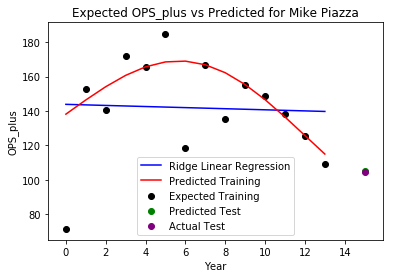

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.619
Variance score for LR: 0.024


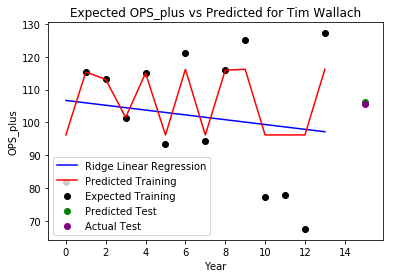

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.286
Variance score for LR: 0.353


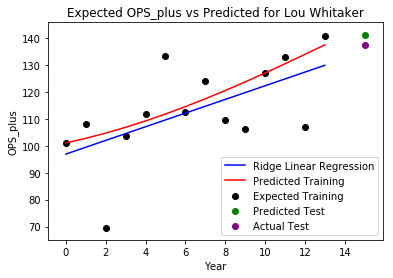

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.861
Variance score for LR: 0.187


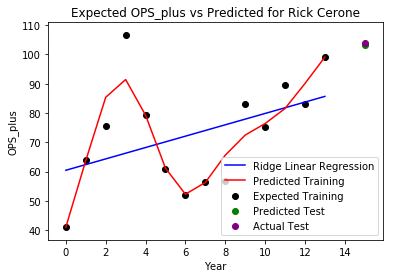

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.708
Variance score for LR: 0.001


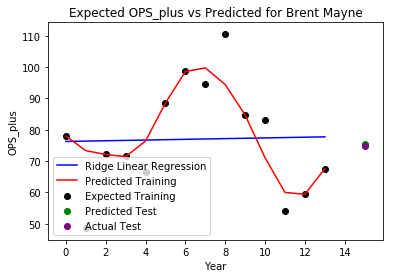

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.128
Variance score for LR: 0.140


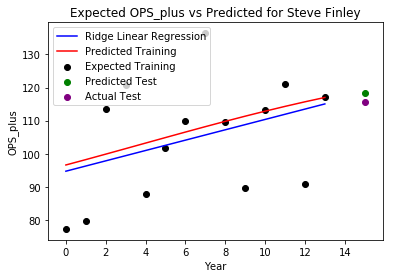

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.003
Variance score for LR: 0.138


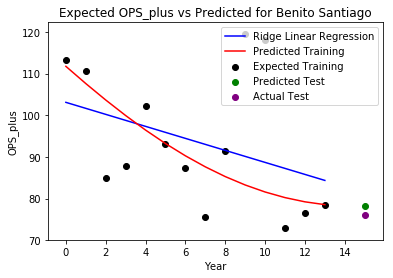

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.382
Variance score for LR: 0.030


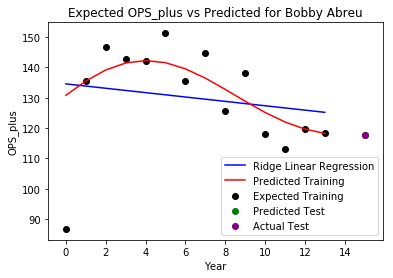

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: -0.027
Variance score for LR: 0.034


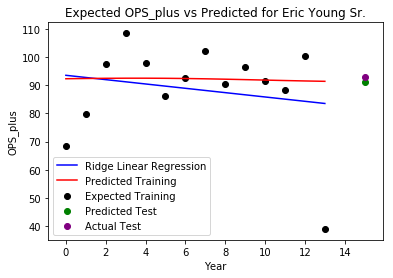

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.280
Variance score for LR: 0.375


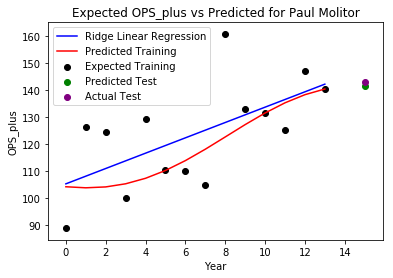

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.250
Variance score for LR: 0.064


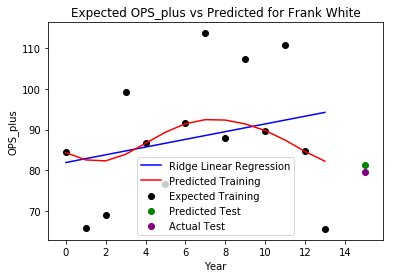

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.198
Variance score for LR: 0.259


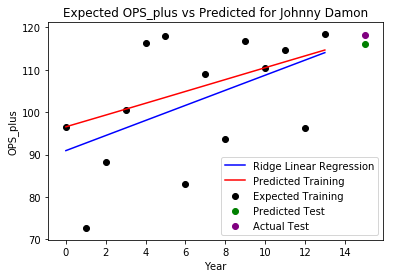

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.526
Variance score for LR: 0.511


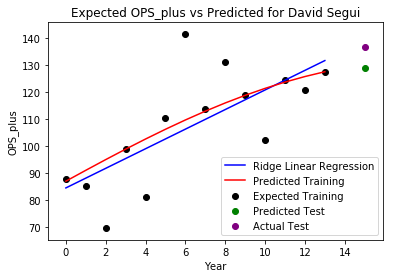

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.001
Variance score for LR: 0.091


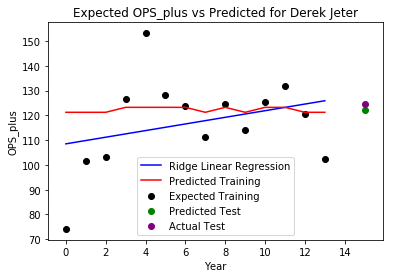

/Users/StephanieBrito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Variance score for SVR: 0.662
Variance score for LR: 0.288


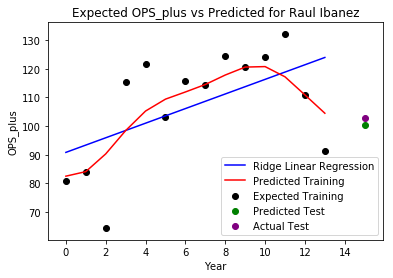

In [612]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# analysis on best 10 with just OPS_plus:

for player in best_ten:
    player_name = player[0]
    player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player_name]
    data = prepare_rows(player_rows)
    data_tuple = prepare_test_train(data[0], data[1])
    x_train, y_train, x_test, y_test = data_tuple

    parameters = {
        "kernel": ["rbf"],
        "C": [1,10,10,100,150,1000],
        "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e8],
        "epsilon": [0.1, 0.01]
        }

    svr = GridSearchCV(SVR(), parameters, cv=3)
    svr.fit(x_train, y_train.ravel())
    y_svr_pred = svr.predict(x_test)
    linearRegressor = Ridge(alpha=0.1)  # ditto for alpha
    linearRegressor.fit(x_train, y_train)  
    plt.plot(x_train, linearRegressor.predict(x_train), color = 'blue')

    plt.plot(svr.predict(x_train), color = 'red')
    plt.scatter(x_train,y_train, color = 'black')


    plt.scatter(len(y_train) + 1, y_svr_pred, color = 'green')
    plt.scatter(len(y_train) + 1, y_test, color = 'purple')
    plt.legend(('Ridge Linear Regression','Predicted Training', 'Expected Training', 'Predicted Test','Actual Test'))
    print('Variance score for SVR: %.3f' % r2_score(y_train, svr.predict(x_train)))
    print('Variance score for LR: %.3f' % r2_score(y_train, linearRegressor.predict(x_train)))




    plt.title('Expected OPS_plus vs Predicted for %s' % player_name)
    plt.xlabel('Year')
    plt.ylabel('OPS_plus')
    plt.show()

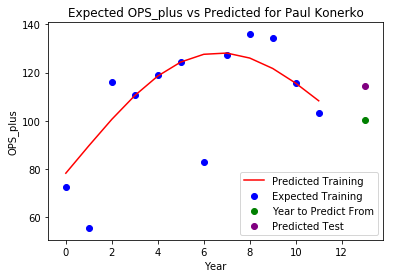

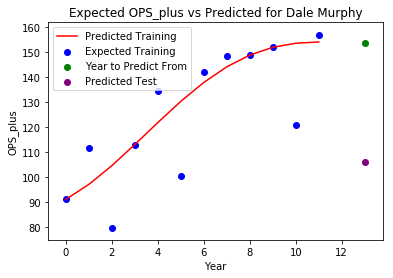

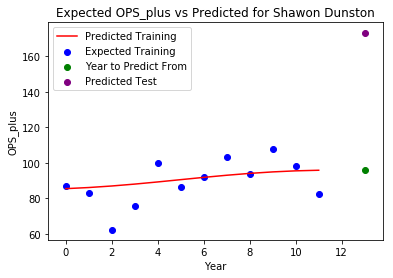

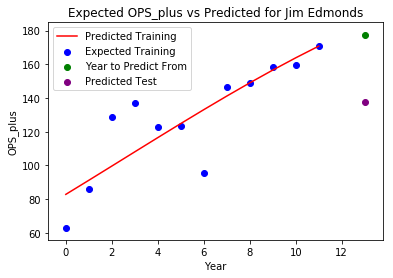

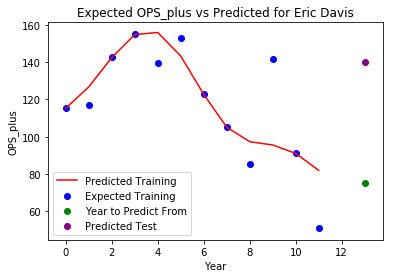

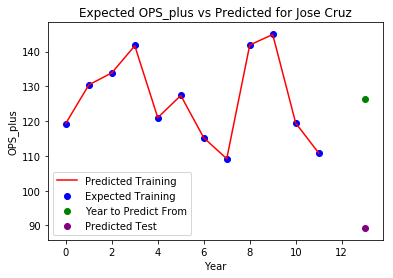

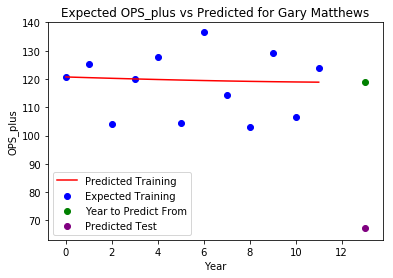

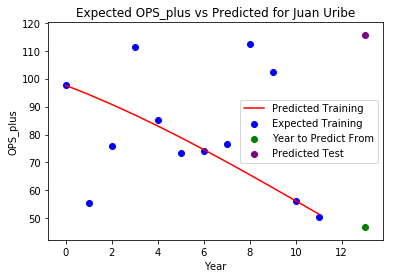

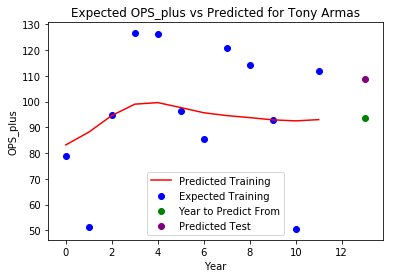

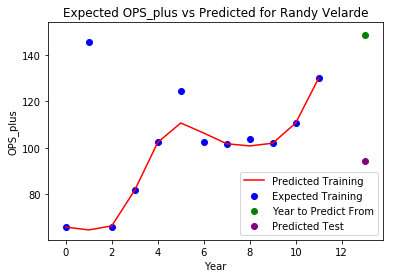

In [599]:
for player in worst_ten:
    player_name = player[0]
    player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player_name]
    data = prepare_rows(player_rows)
    data_tuple = prepare_test_train(data[0], data[1])
    x_train, y_train, x_test, y_test = data_tuple

    parameters = {
        "kernel": ["rbf"],
        "C": [1,10,10,100,150,1000],
        "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e8],
        "epsilon": [0.1, 0.01]
        }

    svr = GridSearchCV(SVR(), parameters, cv=3)
    svr.fit(x_train, y_train.ravel())
    y_svr_pred = svr.predict(x_test)


    X_grid = np.arange(min(x_train[:,:1]), max(x_train[:,:1]), 0.1)
    X_grid = X_grid.reshape((len(X_grid), 1))

    plt.plot(svr.predict(x_train), color = 'red')
    plt.scatter(x_train,y_train, color = 'blue')


    plt.scatter(len(y_train) + 1, y_svr_pred, color = 'green')
    plt.scatter(len(y_train) + 1, y_test, color = 'purple')
    plt.legend(('Predicted Training', 'Expected Training', 'Year to Predict From', 'Predicted Test','Actual Test'))

    plt.title('Expected OPS_plus vs Predicted for %s' % player_name)
    plt.xlabel('Year')
    plt.ylabel('OPS_plus')
    plt.show()

In [469]:
df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == 'Tony Phillips']

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,...,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg
76207,Tony Phillips,23.0,120522.0,phillto02,1982,OAK,1,AL,100.0,40,...,4.39585,1.869,1.863,0.5052,0.5007,0.5092,0.4910,74.5133,30.391,31.720
76208,Tony Phillips,24.0,120522.0,phillto02,1983,OAK,1,AL,476.0,148,...,4.38778,1.872,1.864,0.4982,0.5036,0.5006,0.4885,85.3142,147.916,159.897
76209,Tony Phillips,25.0,120522.0,phillto02,1984,OAK,1,AL,505.0,154,...,4.31999,1.864,1.856,0.5015,0.5036,0.5038,0.4881,96.7953,157.119,172.913
76210,Tony Phillips,26.0,120522.0,phillto02,1985,OAK,1,AL,178.0,42,...,4.43841,1.890,1.872,0.5288,0.5163,0.5157,0.4850,120.7747,55.353,62.935
76211,Tony Phillips,27.0,120522.0,phillto02,1986,OAK,1,AL,532.0,118,...,4.49203,1.893,1.878,0.5235,0.5113,0.5154,0.4850,102.9071,166.628,173.357
76212,Tony Phillips,28.0,120522.0,phillto02,1987,OAK,1,AL,441.0,111,...,4.79824,1.920,1.913,0.5041,0.5002,0.5071,0.4867,94.3616,142.192,156.186
76213,Tony Phillips,29.0,120522.0,phillto02,1988,OAK,1,AL,251.0,79,...,4.27049,1.853,1.849,0.4850,0.4953,0.4902,0.4884,79.4297,80.100,81.705
76214,Tony Phillips,30.0,120522.0,phillto02,1989,OAK,1,AL,524.0,143,...,4.19154,1.851,1.841,0.5039,0.5027,0.5039,0.4858,99.1579,166.962,170.749
76215,Tony Phillips,31.0,120522.0,phillto02,1990,DET,1,AL,687.0,152,...,4.17735,1.855,1.841,0.5169,0.5081,0.5110,0.4836,100.9057,222.926,223.069
76216,Tony Phillips,32.0,120522.0,phillto02,1991,DET,1,AL,655.0,146,...,4.32211,1.876,1.858,0.5206,0.5140,0.5061,0.4838,121.9524,216.073,224.641


In [ ]:
## OLD CODE -- doing the analysis with all features

# for the player specific SVR, I will choose players with at least 20 years of activity. 
# the data will be split as follows:
# x_train: year 0-5 data. the shape is: (num_samples, num_features) -> (6, num_features)
# y_train: year 6-12 OPS_plus. the shape is: (num_samples, 1) -> (6,1)

# x_test: year 13-14 data
# y_test: year 14-15 data



In [ ]:
def prepare_test_train(player_x_data, player_y_data):
    i_0, i_1, i_2, i_3 = 6, 12, 13, 14 # hardcoded for now. these are just the ranges described above
    x_train = player_x_data[:i_0,:]
    y_train = player_y_data[i_0:i_1]
    x_test = player_x_data[i_1:i_2]
    y_test = player_y_data[i_2: i_3]
    return (x_train, y_train, x_test, y_test)

In [ ]:
from sklearn import preprocessing

def prepare_rows(player_rows):
    player_x_data =player_rows[['age', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR']].values
    player_y_data = player_rows[['OPS_plus']].values
    return (preprocessing.scale(player_x_data), preprocessing.scale(player_y_data))

In [ ]:
from collections import defaultdict
loss_dict = defaultdict(float)
tot_mse_loss = 0
tot_mae_loss = 0
y_true = []
y_pred = []

for player in players_with_more_than_20_years:
    print(player)
    player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player]
    data = prepare_rows_new(player_rows)
    data_tuple = prepare_test_train_new(data[0], data[1])
    results = run_svr(data_tuple)
    loss_dict[player] = results
    y_true.append(results[0][0])
    y_pred.append(results[1][0])
    tot_mse_loss += loss_dict[player][-1]
    tot_mae_loss += loss_dict[player][-2]

In [ ]:

# analysis on best 10:

for player in best_ten:
    player_name = player[0]
    player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player_name]
    data = prepare_rows(player_rows)
    data_tuple = prepare_test_train(data[0], data[1])
    x_train, y_train, x_test, y_test = data_tuple

    parameters = {
        "kernel": ["rbf"],
        "C": [1,10,10,100,150,1000],
        "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e8],
        "epsilon": [0.1, 0.01]
        }

    svr = GridSearchCV(SVR(), parameters, cv=3)
    svr.fit(x_train, y_train.ravel())
    y_svr_pred = svr.predict(x_test)
    
    

    X_grid = np.arange(min(x_train[:,:1]), max(x_train[:,:1]), 0.1)
    X_grid = X_grid.reshape((len(X_grid), 1))

    plt.plot(svr.predict(x_train), color = 'red')
    plt.plot(y_train, color = 'blue')


    plt.scatter(len(y_train),  x_test[0][-1], color = 'black')
    plt.scatter(len(y_train) + 1, y_svr_pred, color = 'green')
    plt.scatter(len(y_train) + 1, y_test, color = 'purple')
    plt.legend(('Predicted Training', 'Expected Training', 'Year to Predict From', 'Predicted Test','Actual Test'))

    plt.title('Expected OPS_plus vs Predicted for %s' % player_name)
    plt.xlabel('Year')
    plt.ylabel('OPS_plus')
    plt.show()